In [1]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
import shap
from feature_engine.selection import DropCorrelatedFeatures

In [2]:
# 타이타닉데이터로 보루타 알고리즘으로 피처를 선정하자!

df = sns.load_dataset('titanic')

#데이터 전처리

df = df.dropna(subset=['age','embarked','deck'])
df['sex'] =df['sex'].map({'male':0,'female':1})
df['embarked'] =df['embarked'].astype('category').cat.codes
df['deck'] = df['deck'].astype('category').cat.codes

#필요한 피처만 추출

X = df[['pclass','sex','age','sibsp','parch','fare','embarked','deck']]
y = df['survived']

In [3]:
## 보루타를 통한 피처셀렉션을 위해 RandomForestClassifier

rf= RandomForestClassifier(class_weight = 'balanced', max_depth=5)

# BorutaPy 불러오기
boruta_selector = BorutaPy(rf, n_estimators = 'auto', random_state=111)
boruta_selector.fit(X.values, y.values) #행렬로 대입해서

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=80,
                                          random_state=RandomState(MT19937) at 0x240A0DF2540),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x240A0DF2540)

In [4]:
print('선택된 특성',X.columns[boruta_selector.support_].tolist())

선택된 특성 ['sex', 'age', 'fare']


- 모든 특성의 중요도를 평가하고, 쉐도우 변수를 만들어서 무작위로 중요도를 뽑아서 비교 하고
- 이 무작위보다 높은 중요도를 가진 특성들을 추출한 것

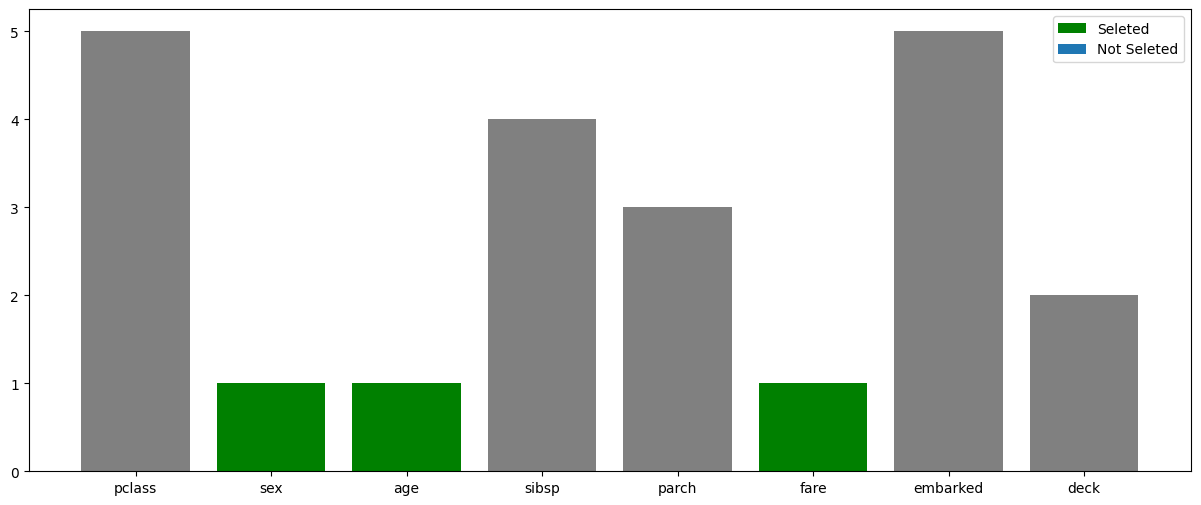

In [5]:
import matplotlib.pyplot as plt

green_area = X.columns[boruta_selector.support_].tolist()
blue_area = X.columns[boruta_selector.support_weak_].tolist()

# 중요도 랭킹으로 확인하기
feature_importance = boruta_selector.ranking_

# 시각화로 살펴보기

plt.figure(figsize=(15,6))
plt.bar(X.columns, feature_importance,color= 'grey')
plt.bar(green_area, [1]*len(green_area), color='green', label='Seleted')
plt.bar(blue_area, [2]*len(blue_area), color='blue', label='Not Seleted')
plt.legend()

# Shap value(샤플리 값)

- 샤플리 값의 작동 방식을 이해하자!
- 간단한 예시를 통해 어떤 식으로 계산하는지 이해하기!
    - 세 명의 플레이어(피처) A, B, C가 협력해서 100의 매출들 달성 (ML y값을 예측한다,)
    - A와 B가 같이 협력하면 매출 60 달성
    - B와 C가 같이 협력하면 매출 50 달성
    - A, B, C가 모두 협력하면 매출 100을 달성
    - 기여도는 어떤 식으로 계산이 될까?
        - 각 조합의 기여도를 계산
        - 공집합 = 기여도가 0, A, B, C 모두 진행 X
        - A만 한 경우 20, B만한 경우 30, C만한 경우 10
        - A, B = 60, B, C = 50
    - 샤플리 값 A를 계산한다고 하면 샤플리 값 = 1/6(20) + 1/6(10) + 1/6(40-10) + 1/6(60-30) + 1/6(100-60)
- Machine Learning에서 샤플리 값을 계산한다면?
  - Feature 모델의 예측값에 기여한 정도를 계산하기 위해 샤플리 값을 사용한다.
  - 피처들의 조합으로 게임 플레이어처럼 생각하고, 모델의 예측 값을 협력의 결과로 본다.
  - 데이터 포인트에 대해 모델의 예측 값 계산
  - 모든 특성의 조합에서의 예측 값이 변화를 계산
  - 각 특성의 기여도를 평균화해서 샤플리 값을 계산

# 샤플리 값을 타이타닉 데이터로 설명해 보면
- 타이타닉의 주요 특성(피처) pclass, sex, age, fare 타겟 변수는 survived
- 랜덤 포레스트를 학습해서 특정 포인트에서 샤플리 값을 계산
----
- 특성 N은
  - Pclass(객실 등급), Sex(성별), Age(나이), Fare(요금)

- **모든 특성의 조합을 생각해야 한다. **
  - 공집합,
  - Pclass
  - Sex
  - Age
  - Fare
  - (Pclass, Sex)
  - ...
  - (Pclass, Sex, Age, Fare)
  - 모든 조합을 생성한다.

- 모델의 예측 값을 계산
  - 수식에서 바라보면
  - S = pclass i = sex , pclass와 sex를 함께 사용하여 예측값을 계산
  - f(SU{i} - f(S}) 특성인 sex 추가가 되었을 때 예측값에 미친 변화량을 계산

- 평균화
    - 모든 부분집합 (S)에 대한 기여도를 계산하는 것, 이를 평균화하여 특성 (i) 샤플리 값을 얻는 것

- 특정 데이터 포인트에 대해 샤플리값을 다계산이 된다.
- 변수     샤플리값     해석
- pclass  -0.3     낮은 객실등급들이 생존 확률을 감소시킨다.
- sex     +0.5     여성의 경우 생존확률 증가시킨다.
- age     -0.2     나이가 많아질수록 생존에 대한 확률이 감소
- fare    +0.1     운임이 높으면 생존확률을 증가시킨다.

    - **타이타닉의 도메인을 이해하고 샤플리값을 바라보면 피처에 대한 선택과 인사이트를 상대적으로 쉽게 정리할 수 있다.**

In [6]:
from sklearn.model_selection import train_test_split

X = df[['sex', 'age', 'fare', 'pclass']]
y = df['survived']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=111)

In [9]:
model = RandomForestClassifier(random_state=111)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=111)

In [10]:
# Shap 값 구하기
# SHAP Explainer

explainer=shap.TreeExplainer(model)

In [11]:
# shap_values 추출
shap_values=explainer.shap_values(X_test)

In [12]:
shap_values

array([[[ 2.21466861e-01, -2.21466861e-01],
        [ 1.13594209e-01, -1.13594209e-01],
        [-2.06209208e-01,  2.06209208e-01],
        [-2.69185556e-04,  2.69185556e-04]],

       [[-1.50051199e-01,  1.50051199e-01],
        [-7.65689293e-02,  7.65689293e-02],
        [-6.35779054e-02,  6.35779054e-02],
        [-2.12192893e-02,  2.12192893e-02]],

       [[ 3.06207651e-01, -3.06207651e-01],
        [ 3.82706060e-02, -3.82706060e-02],
        [ 2.08374207e-01, -2.08374207e-01],
        [ 5.73021357e-03, -5.73021357e-03]],

       [[-1.94451182e-01,  1.94451182e-01],
        [-5.48092467e-02,  5.48092467e-02],
        [-6.84494051e-02,  6.84494051e-02],
        [-3.70748949e-03,  3.70748949e-03]],

       [[ 2.00072782e-01, -2.00072782e-01],
        [-3.04022517e-02,  3.04022517e-02],
        [-1.16545064e-01,  1.16545064e-01],
        [-4.54278848e-03,  4.54278848e-03]],

       [[-1.70773447e-01,  1.70773447e-01],
        [-7.32136894e-02,  7.32136894e-02],
        [-7.22896634e-

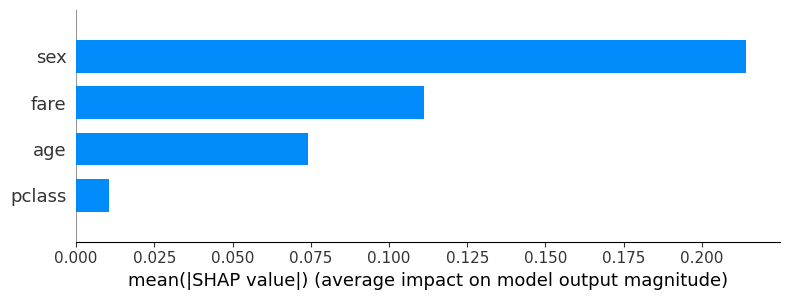

In [13]:
# 특정 클래스 선택 (예: 클래스 0)
shap_values_class_0 = shap_values[:, :, 0]

# 요약 플롯 생성
shap.summary_plot(shap_values_class_0, X_test, plot_type='bar', feature_names=X_test.columns.tolist())

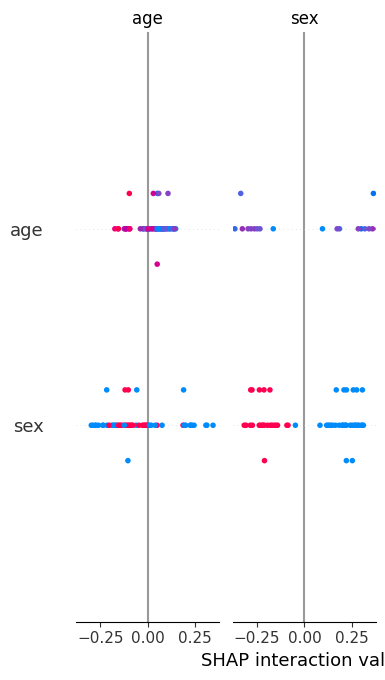

In [19]:
shap.summary_plot(shap_values, X_test, plot_type='bar')